# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from agent import Agent
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

Episode: 100	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.01589
Episode: 200	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.001
Episode: 300	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.028288
Episode: 400	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.001
Episode: 500	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.0
Episode: 600	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.003033
Episode: 700	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.017177
Episode: 800	Current Score: 0.0	Mean over 10 episodes: 0.02	Mean over 100 episodes: 0.04974
Episode: 900	Current Score: 0.1	Mean over 10 episodes: 0.09	Mean over 100 episodes: 0.047
Episode: 1000	Current Score: 0.1	Mean over 10 episodes: 0.08	Mean over 100 episodes: 0.1297
Episode: 1100	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.017776
E

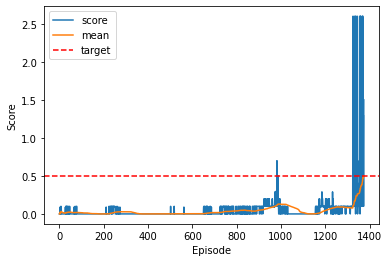

In [5]:
min_noise = 0.1
noise_decay = 0.999
noise_factor = 1.0
random_seed = 1
random_episodes = 100
max_episodes = 5000
max_t = 10000

#variable to safe the best net
current_best = 0
#boolean to show if task is fullfilled
ready = False

# create a new agent
agent = Agent(state_size = state_size, action_size=action_size, random_seed=random_seed)

def maddpg(n_episodes, max_t):
    scores_window = deque(maxlen=100)
    scores = []
    means = []
    noise_f = noise_factor
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        #get the current states
        states = env_info.vector_observations
        #initialize score for one episode
        e_scores = np.zeros(2)
        #reset the agent
        agent.reset()
        #set the timestep
        timestep=0
        for t in range(max_t):
            #use random actions the first few episodes to collect some information about the environment
            if episode < random_episodes:
                actions = np.random.randn(2, 2)
            #select actions according to the agents networks
            else:
                actions = agent.act(states, noise_factor=noise_f)
            actions_second_player = np.flip(actions, 0)
            #execute the actions
            env_info = env.step(actions)[brain_name] 
            #get the next_states, rewards and informations if episode has finished
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            next_states_second_player = np.flip(next_states, 0)
            dones = env_info.local_done
            #take a step
            agent.step(states, actions, actions_second_player, rewards, next_states, next_states_second_player, dones, timestep)
            #roll over the states
            states = next_states
            #add the reward to the score
            e_scores += rewards
            #count the timestep
            timestep+=1
            if np.any(dones):
                break
        #get the maximum score of both agents
        max_score = np.max(e_scores)
        scores_window.append(max_score)
        scores.append(max_score)
        means.append(np.mean(scores_window))
        #reduce the noise
        noise_f = max(noise_decay * noise_f, min_noise)
        print("Episode: " + str(episode) + "\tCurrent Score: " + str(round(max_score,3)) + 
              "\tMean over 10 episodes: " + str(round(np.mean(list(scores_window)[-10:]),3)) +
              "\tMean over 100 episodes: " + str(round(np.mean(scores_window),3)), end = "\r")
        global current_best
        global ready
        if episode > 100 and np.mean(scores_window) > current_best:
            torch.save(agent.actor_local.state_dict(), 'Weights/checkpoint_Actor.pth')
            torch.save(agent.critic_local.state_dict(), 'Weights/checkpoint_Critic.pth')
            current_best = np.mean(scores_window)
            if np.mean(scores_window) >= 0.5 and ready == False:
                print("Environment solved in " + str(episode) + " episodes. Max score: " +
                      str(round(np.mean(scores_window),3)) + " for the last 100 episodes")
                ready = True
                break;
        if episode % 100 == 0:
            print("Episode: " + str(episode) + "\tCurrent Score: " + str(round(max_score,3)) + 
              "\tMean over 10 episodes: " + str(round(np.mean(list(scores_window)[-10:]),3)) +
              "\tMean over 100 episodes: " + str(round(np.mean(scores_window),3)))
            
    return scores, means

scores, means = maddpg(max_episodes, max_t)

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=0.5, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```